In [14]:
import kagglehub

# Download latest version
# path = kagglehub.dataset_download("piterfm/fifa-football-world-cup")
path = kagglehub.dataset_download("sanjeetsinghnaik/la-liga-match-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/la-liga-match-data


Biblioteki

In [15]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from helpers import *


Pomoc przy dataset

In [16]:
def getColumnLabels(dataset):
    if dataset == "laliga":
        return [["Home Team Goals Scored", "Away Team Goals Scored"],
                ["Home Team", "Away Team"]]
    elif dataset == "worldcup":
        return [["home_score", "away_score"],
                ["home_team", "away_team"]]

In [17]:
def loadDataset(path):
    return pd.read_csv(path)

def getMatchResult(row, labels):
    if row[labels[0]] > row[labels[1]]:
        return 'H'
    elif row[labels[0]] < row[labels[1]]:
        return 'A'
    else:
        return 'D'

def predictMatch(home, away):
    # Encode home and away teams separately using their encoders
    home_encoded = le_home_encoder.transform([[home]]).toarray()
    away_encoded = le_away_encoder.transform([[away]]).toarray()

    # Combine the team encoding
    team_input = np.hstack((home_encoded, away_encoded))

    # Compute numeric features
    home_shots = home_avg_shots.get(home, 0)
    away_shots = away_avg_shots.get(away, 0)
    home_corners = home_avg_corners.get(home, 0)
    away_corners = away_avg_corners.get(away, 0)

    numeric_input = scaler.transform([[home_shots, away_shots, home_corners, away_corners]])

    # Combine both team and numeric inputs
    input_data = np.hstack((team_input, numeric_input))

    # Predict
    pred_probs = model.predict(input_data)[0]
    label_order = le_target.transform(['H', 'D', 'A'])

    # Output
    print(f"\n{home} vs {away}")
    print(f"Home win: {pred_probs[label_order[0]]*100:.2f}%")
    print(f"Draw:     {pred_probs[label_order[1]]*100:.2f}%")
    print(f"Away win: {pred_probs[label_order[2]]*100:.2f}%")


In [18]:
# dataset_path = "datasets/worldcup/matches_1930_2022.csv"
dataset_path = "datasets/laliga/combined_data_laliga.csv"
dataset = dataset_path.split('/')[1]

test_ratio = 0.4
labels = getColumnLabels(dataset)

df = loadDataset(dataset_path)
df['result'] = df.apply(getMatchResult, args=(labels[0], ), axis=1)

In [19]:
home_avg_shots = df.groupby("Home Team")["Home Team Total Shots"].mean()
away_avg_shots = df.groupby("Away Team")["Away Team Total Shots"].mean()
home_avg_corners = df.groupby("Home Team")["Home Team Corners"].mean()
away_avg_corners = df.groupby("Away Team")["Away Team Corners"].mean()

df['home_avg_shots'] = df["Home Team"].map(home_avg_shots)
df['away_avg_shots'] = df["Away Team"].map(away_avg_shots)
df['home_avg_corners'] = df["Home Team"].map(home_avg_corners)
df['away_avg_corners'] = df["Away Team"].map(away_avg_corners)

# === Prepare Features ===
team_features = df[["home_avg_shots", "away_avg_shots", "home_avg_corners", "away_avg_corners"]].values
scaler = StandardScaler()
scaled_team_features = scaler.fit_transform(team_features)

le_home_encoder = OneHotEncoder(handle_unknown='ignore')
le_home_encoded = le_home_encoder.fit(df[[labels[1][0]]])
le_home = le_home_encoded.transform(df[[labels[1][0]]]).toarray()

le_away_encoder = OneHotEncoder(handle_unknown='ignore')
le_away_encoded = le_away_encoder.fit(df[[labels[1][1]]])
le_away = le_away_encoded.transform(df[[labels[1][1]]]).toarray()

# Combine all features
X = np.hstack((le_home, le_away, scaled_team_features))

# Encode targets
le_target = LabelEncoder()
Y = le_target.fit_transform(df['result'])

# === Train-test Split ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [20]:
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=le_target.classes_,
    y=df['result']
)

class_weight_dict = dict(zip(le_target.transform(le_target.classes_), class_weights))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs = 100,
          batch_size = 16, validation_split=0.5,
          class_weight=class_weight_dict
          )

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3003 - loss: 1.1699 - val_accuracy: 0.2719 - val_loss: 1.1077
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3516 - loss: 1.1233 - val_accuracy: 0.4599 - val_loss: 1.0733
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3066 - loss: 1.1504 - val_accuracy: 0.4624 - val_loss: 1.0706
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3558 - loss: 1.1322 - val_accuracy: 0.4273 - val_loss: 1.0823
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3851 - loss: 1.0924 - val_accuracy: 0.3496 - val_loss: 1.0744
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3857 - loss: 1.0790 - val_accuracy: 0.4411 - val_loss: 1.0645
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3597 - loss: 1.0843 - val_accuracy: 0.4211 - val_loss: 1.0708
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4472 - loss: 1.0607 - val_accuracy: 0.4649 - v

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Test Accuracy: 43.05%
Test MSE: 1.0517


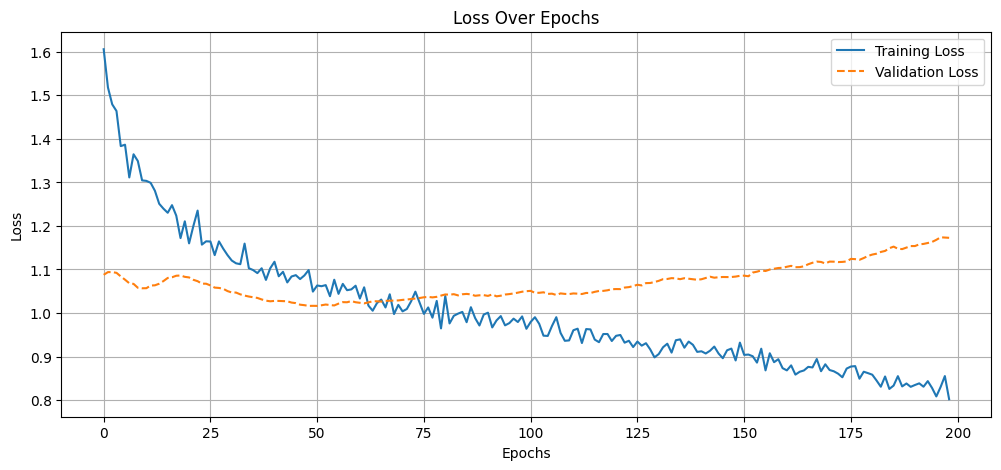

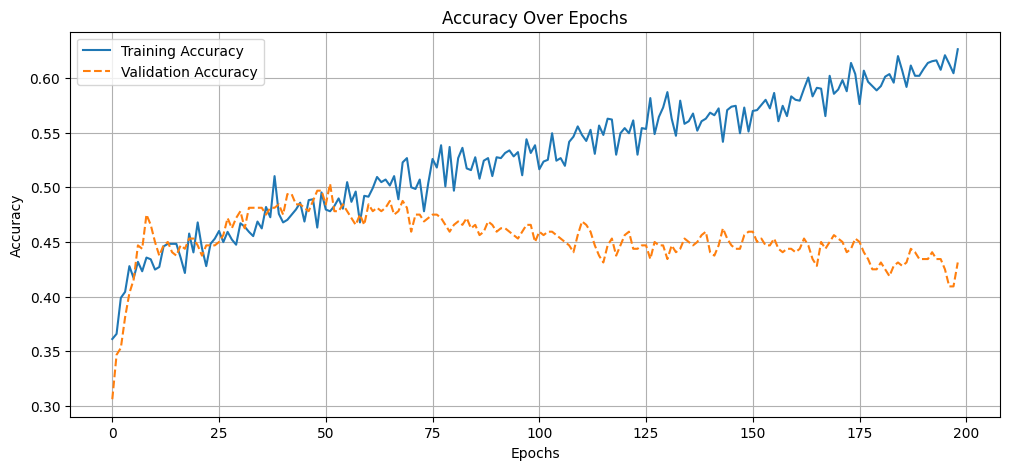

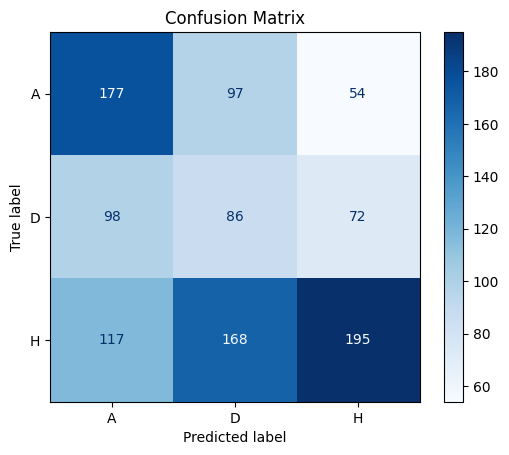

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

# Ewaluacja modelu na danych testowych
score = model.evaluate(X_test, Y_test, verbose=0)
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Obliczanie MSE dla danych testowych
mse = mean_squared_error(Y_test, predicted_classes)
print(f'\nTest Accuracy: {score[1] * 100:.2f}%')
print(f'Test MSE: {mse:.4f}')

# --- Wykresy ---
# Wykres strat treningu i walidacji
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Wykres dokładności treningu i walidacji
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# --- Macierz pomyłek ---
cm = confusion_matrix(Y_test, predicted_classes, labels=np.arange(len(le_target.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_target.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [23]:
predictMatch("BARCELONA", "REAL MADRID")
predictMatch("REAL MADRID", "BARCELONA")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(



BARCELONA vs REAL MADRID
Home win: 70.80%
Draw:     13.96%
Away win: 15.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

REAL MADRID vs BARCELONA
Home win: 39.58%
Draw:     18.01%
Away win: 42.41%


In [24]:
df['result'].value_counts(normalize=True)

,proportion
result,
H,0.456391
A,0.287218
D,0.256391
